In [8]:
from IPython.display import HTML
from base64 import b64encode
import imgaug.augmenters as iaa
import math

import numpy as np
import cv2
import os
from keras.models import load_model
from collections import deque
from tqdm import tqdm
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib
matplotlib.use("Agg")
from keras.layers import Input
from keras.models import Model
from keras.layers.core import Dense
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50V2
from keras import regularizers
from keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import seaborn as sns
from sklearn import metrics

In [9]:
PROJECT_DIR = 'C:/Users/anikr/Desktop/CSE_499A_Project/Dataset/'

In [10]:
from IPython.display import HTML
from base64 import b64encode

def play(filename):
    html = ''
    video = open(filename,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

In [11]:
play('C:/Users/anikr/Desktop/CSE_499A_Project/Dataset/Real Life Violence Dataset/Violence/V_1.mp4')

In [12]:
IMG_SIZE = 128
ColorChannels = 3

def video_to_frames(video):
    vidcap = cv2.VideoCapture(video)
    
    
    rate = math.floor(vidcap.get(3))
    count = 0
    
    ImageFrames = []
    while vidcap.isOpened():
        ID = vidcap.get(1)
        success, image = vidcap.read()
        
        if success:
            # skipping frames to avoid duplications 
            if (ID % 7 == 0):
                flip = iaa.Fliplr(1.0)
                zoom = iaa.Affine(scale=1.3)
                random_brightness = iaa.Multiply((1, 1.3))
                rotate = iaa.Affine(rotate=(-25, 25))
                
                image_aug = flip(image = image)
                image_aug = random_brightness(image = image_aug)
                image_aug = zoom(image = image_aug)
                image_aug = rotate(image = image_aug)
                
                rgb_img = cv2.cvtColor(image_aug, cv2.COLOR_BGR2RGB)
                resized = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))
                ImageFrames.append(resized)
                
            count += 1
        else:
            break
    
    vidcap.release()
    
    return ImageFrames

In [ ]:
%%time
from tqdm import tqdm

VideoDataDir = PROJECT_DIR + '/Real Life Violence Dataset'
print('\n{} Violence videos \n{} NonViolence videos'.format(
              len(os.listdir(VideoDataDir + '/Violence')), 
              len(os.listdir(VideoDataDir + '/NonViolence'))))

X_original = []
y_original = []

CLASSES = ["NonViolence", "Violence"]


for category in os.listdir(VideoDataDir):
    path = os.path.join(VideoDataDir, category)
    class_num = CLASSES.index(category)
    for i, video in enumerate(tqdm(os.listdir(path)[0:1000])):
        frames = video_to_frames(path + '/' + video)
        for j, frame in enumerate(frames):
            X_original.append(frame)
            y_original.append(class_num)

In [6]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [14]:
X_original = np.array(X_original).reshape(-1 , IMG_SIZE * IMG_SIZE * 3)
y_original = np.array(y_original)
len(X_original)

7990

In [15]:
stratified_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=73)

for train_index, test_index in stratified_sample.split(X_original, y_original):
    X_train, X_test = X_original[train_index], X_original[test_index]
    y_train, y_test = y_original[train_index], y_original[test_index]

X_train_nn = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255
X_test_nn = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255

In [20]:
epochs = 150


kernel_regularizer = regularizers.l2(0.001)


def load_layers():
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, ColorChannels))
    baseModel = ResNet50V2(weights = "imagenet", pooling='avg',
                            include_top=False, 
                            input_tensor=input_tensor)
    
    headModel = baseModel.output   
    headModel = Dense(1, activation="sigmoid")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)

    for layer in baseModel.layers:
        layer.trainable = False

    print("Compiling model...")
    model.compile(loss="binary_crossentropy",
                    optimizer='adam',
                    metrics=["accuracy"])

    return model


model = load_layers()

model.summary()

Compiling model...
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 66, 66, 64)   0           ['conv1_

 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 32, 32, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 32, 32, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 32, 32, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
          

 conv3_block2_2_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 16, 16, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_out (Add)         (None, 16, 16, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_conv[0][0]']    
          

                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_pad (ZeroPaddin  (None, 10, 10, 256)  0          ['conv4_block1_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_blo

 conv4_block3_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block3_2_relu[0][0]']    
                                                                                                  
 conv4_block3_out (Add)         (None, 8, 8, 1024)   0           ['conv4_block2_out[0][0]',       
                                                                  'conv4_block3_3_conv[0][0]']    
                                                                                                  
 conv4_block4_preact_bn (BatchN  (None, 8, 8, 1024)  4096        ['conv4_block3_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv4_block4_preact_relu (Acti  (None, 8, 8, 1024)  0           ['conv4_block4_preact_bn[0][0]'] 
 vation)                                                                                          
          

 g2D)                                                                                             
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 4, 4, 256)    589824      ['conv4_block6_2_pad[0][0]']     
                                                                                                  
 conv4_block6_2_bn (BatchNormal  (None, 4, 4, 256)   1024        ['conv4_block6_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, 4, 4, 256)   0           ['conv4_block6_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 max_pooli

 ormalization)                                                                                    
                                                                                                  
 conv5_block3_preact_relu (Acti  (None, 4, 4, 2048)  0           ['conv5_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 4, 4, 512)    1048576     ['conv5_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, 4, 4, 512)   2048        ['conv5_block3_1_conv[0][0]']    
 ization)                                                                                         
          

In [21]:
patience = 3

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005

batch_size = 20



rampup_epochs = 30
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if ((logs.get('accuracy')>=0.99)):
            print("\nLimits Reached cancelling training!")
            self.model.stop_training = True

In [22]:
end_callback = myCallback()

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

early_stopping = EarlyStopping(patience = patience, monitor='val_loss',
                                 mode='min', restore_best_weights=True, 
                                 verbose = 1, min_delta = .00075)



lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

os.system('rm -rf ./logs/')


log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

checkpoint_filepath = 'ModelWeights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)


callbacks = [end_callback, lr_callback, model_checkpoints, tensorboard_callback, early_stopping, lr_plat]

In [23]:
print('Training head...')
batch_size = 50
#model.load_weights('./Model_Weights.h5')

history = model.fit(X_train_nn ,y_train, epochs=epochs,
                        callbacks=callbacks,
                        validation_data = (X_test_nn, y_test),
                        batch_size=batch_size)

print('\nRestoring best Weights for ResNet50V2')
model.load_weights(checkpoint_filepath)

Training head...
Epoch 1/150
112/112 [==============================] - ETA: 0s - loss: 1.0525 - accuracy: 0.5192
Epoch 1: val_loss improved from inf to 1.00160, saving model to ModelWeights.h5
112/112 [==============================] - 88s 764ms/step - loss: 1.0525 - accuracy: 0.5192 - val_loss: 1.0016 - val_accuracy: 0.5015 - lr: 1.0000e-05
Epoch 2/150
112/112 [==============================] - ETA: 0s - loss: 0.9285 - accuracy: 0.5131
Epoch 2: val_loss improved from 1.00160 to 0.90003, saving model to ModelWeights.h5
112/112 [==============================] - 86s 771ms/step - loss: 0.9285 - accuracy: 0.5131 - val_loss: 0.9000 - val_accuracy: 0.5077 - lr: 1.1333e-05
Epoch 3/150
112/112 [==============================] - ETA: 0s - loss: 0.8424 - accuracy: 0.5308
Epoch 3: val_loss improved from 0.90003 to 0.82273, saving model to ModelWeights.h5
112/112 [==============================] - 89s 794ms/step - loss: 0.8424 - accuracy: 0.5308 - val_loss: 0.8227 - val_accuracy: 0.5269 - lr: 1.

112/112 [==============================] - 80s 717ms/step - loss: 0.2079 - accuracy: 0.9290 - val_loss: 0.2163 - val_accuracy: 0.9241 - lr: 4.2000e-05
Epoch 26/150
112/112 [==============================] - ETA: 0s - loss: 0.2005 - accuracy: 0.9324
Epoch 26: val_loss improved from 0.21626 to 0.20961, saving model to ModelWeights.h5
112/112 [==============================] - 77s 688ms/step - loss: 0.2005 - accuracy: 0.9324 - val_loss: 0.2096 - val_accuracy: 0.9270 - lr: 4.3333e-05
Epoch 27/150
112/112 [==============================] - ETA: 0s - loss: 0.1934 - accuracy: 0.9346
Epoch 27: val_loss improved from 0.20961 to 0.20297, saving model to ModelWeights.h5
112/112 [==============================] - 78s 696ms/step - loss: 0.1934 - accuracy: 0.9346 - val_loss: 0.2030 - val_accuracy: 0.9337 - lr: 4.4667e-05
Epoch 28/150
112/112 [==============================] - ETA: 0s - loss: 0.1867 - accuracy: 0.9392
Epoch 28: val_loss improved from 0.20297 to 0.19700, saving model to ModelWeights.h

Epoch 75/150
112/112 [==============================] - ETA: 0s - loss: 0.1167 - accuracy: 0.9626
Epoch 75: val_loss improved from 0.13908 to 0.13856, saving model to ModelWeights.h5
112/112 [==============================] - 75s 669ms/step - loss: 0.1167 - accuracy: 0.9626 - val_loss: 0.1386 - val_accuracy: 0.9529 - lr: 1.0002e-05
Epoch 76/150
112/112 [==============================] - ETA: 0s - loss: 0.1161 - accuracy: 0.9625
Epoch 76: val_loss improved from 0.13856 to 0.13804, saving model to ModelWeights.h5
112/112 [==============================] - 74s 666ms/step - loss: 0.1161 - accuracy: 0.9625 - val_loss: 0.1380 - val_accuracy: 0.9529 - lr: 1.0002e-05
Epoch 77/150
112/112 [==============================] - ETA: 0s - loss: 0.1155 - accuracy: 0.9630
Epoch 77: val_loss improved from 0.13804 to 0.13754, saving model to ModelWeights.h5
112/112 [==============================] - 75s 671ms/step - loss: 0.1155 - accuracy: 0.9630 - val_loss: 0.1375 - val_accuracy: 0.9529 - lr: 1.0001e-0

112/112 [==============================] - 75s 673ms/step - loss: 0.1036 - accuracy: 0.9678 - val_loss: 0.1278 - val_accuracy: 0.9566 - lr: 1.0000e-05
Epoch 100/150
112/112 [==============================] - ETA: 0s - loss: 0.1031 - accuracy: 0.9684
Epoch 100: val_loss improved from 0.12784 to 0.12746, saving model to ModelWeights.h5
112/112 [==============================] - 75s 672ms/step - loss: 0.1031 - accuracy: 0.9684 - val_loss: 0.1275 - val_accuracy: 0.9566 - lr: 1.0000e-05
Epoch 101/150
112/112 [==============================] - ETA: 0s - loss: 0.1026 - accuracy: 0.9682
Epoch 101: val_loss improved from 0.12746 to 0.12709, saving model to ModelWeights.h5
112/112 [==============================] - 75s 670ms/step - loss: 0.1026 - accuracy: 0.9682 - val_loss: 0.1271 - val_accuracy: 0.9566 - lr: 1.0000e-05
Epoch 102/150
112/112 [==============================] - ETA: 0s - loss: 0.1021 - accuracy: 0.9685
Epoch 102: val_loss improved from 0.12709 to 0.12669, saving model to ModelWei

Epoch 124/150
112/112 [==============================] - ETA: 0s - loss: 0.0928 - accuracy: 0.9734
Epoch 124: val_loss improved from 0.11956 to 0.11926, saving model to ModelWeights.h5
112/112 [==============================] - 75s 669ms/step - loss: 0.0928 - accuracy: 0.9734 - val_loss: 0.1193 - val_accuracy: 0.9595 - lr: 1.0000e-05
Epoch 125/150
112/112 [==============================] - ETA: 0s - loss: 0.0924 - accuracy: 0.9732
Epoch 125: val_loss improved from 0.11926 to 0.11897, saving model to ModelWeights.h5
112/112 [==============================] - 75s 669ms/step - loss: 0.0924 - accuracy: 0.9732 - val_loss: 0.1190 - val_accuracy: 0.9595 - lr: 1.0000e-05
Epoch 126/150
112/112 [==============================] - ETA: 0s - loss: 0.0920 - accuracy: 0.9735
Epoch 126: val_loss improved from 0.11897 to 0.11866, saving model to ModelWeights.h5
112/112 [==============================] - 75s 668ms/step - loss: 0.0920 - accuracy: 0.9735 - val_loss: 0.1187 - val_accuracy: 0.9604 - lr: 1.0

112/112 [==============================] - 75s 667ms/step - loss: 0.0844 - accuracy: 0.9759 - val_loss: 0.1127 - val_accuracy: 0.9612 - lr: 1.0000e-05
Epoch 149/150
112/112 [==============================] - ETA: 0s - loss: 0.0841 - accuracy: 0.9764
Epoch 149: val_loss improved from 0.11269 to 0.11243, saving model to ModelWeights.h5
112/112 [==============================] - 75s 669ms/step - loss: 0.0841 - accuracy: 0.9764 - val_loss: 0.1124 - val_accuracy: 0.9625 - lr: 1.0000e-05
Epoch 150/150
112/112 [==============================] - ETA: 0s - loss: 0.0838 - accuracy: 0.9766
Epoch 150: val_loss improved from 0.11243 to 0.11220, saving model to ModelWeights.h5
Restoring model weights from the end of the best epoch: 147.
112/112 [==============================] - 74s 665ms/step - loss: 0.0838 - accuracy: 0.9766 - val_loss: 0.1122 - val_accuracy: 0.9616 - lr: 1.0000e-05
Epoch 150: early stopping

Restoring best Weights for ResNet50V2


In [24]:
%matplotlib inline

def print_graph(item, index, history):
    plt.figure()
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    test_values = history.history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)


def get_best_epoch(test_loss, history):
    for key, item in enumerate(history.history.items()):
        (name, arr) = item
        if name == 'val_loss':
            for i in range(len(arr)):
                if round(test_loss, 2) == round(arr[i], 2):
                    return i
                
def model_summary(model, history):
    print('---'*30)
    test_loss, test_accuracy = model.evaluate(X_test_nn, y_test, verbose=0)

    if history:
        index = get_best_epoch(test_loss, history)
        print('Best Epochs: ', index)

        train_accuracy = history.history['accuracy'][index]
        train_loss = history.history['loss'][index]

        print('Accuracy on train:',train_accuracy,'\tLoss on train:',train_loss)
        print('Accuracy on test:',test_accuracy,'\tLoss on test:',test_loss)
        print_graph('loss', index, history)
        print_graph('accuracy', index, history)
        print('---'*30)

------------------------------------------------------------------------------------------
Best Epochs:  139
Accuracy on train: 0.9751474857330322 	Loss on train: 0.0870295986533165
Accuracy on test: 0.9616186618804932 	Loss on test: 0.11219562590122223


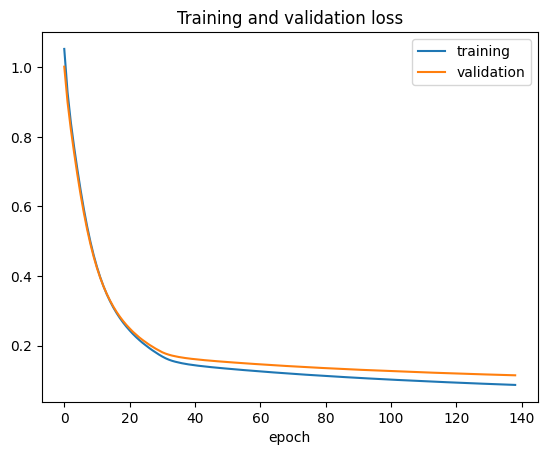

<Figure size 640x480 with 0 Axes>

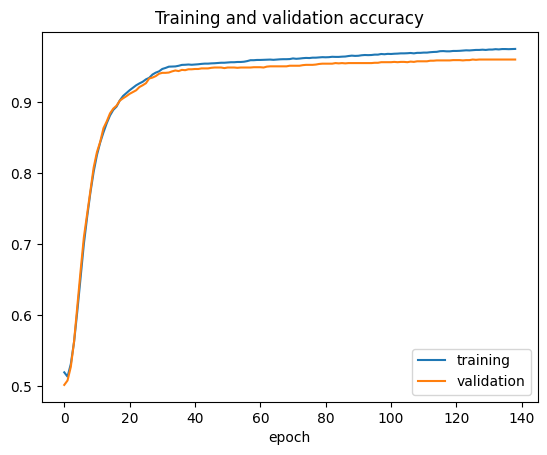

------------------------------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

In [25]:
model_summary(model, history)

In [31]:
print("Evaluating network...")
predictions = model.predict(X_test_nn)
preds = predictions > 0.5

Evaluating network...
75/75 [==============================] - 24s 316ms/step


> Correct Predictions: 2305
> Wrong Predictions: 92


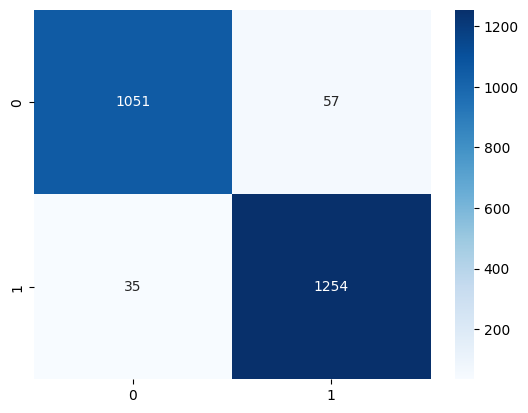

              precision    recall  f1-score   support

 NonViolence       0.97      0.95      0.96      1108
    Violence       0.96      0.97      0.96      1289

    accuracy                           0.96      2397
   macro avg       0.96      0.96      0.96      2397
weighted avg       0.96      0.96      0.96      2397



In [32]:
import seaborn as sns
from sklearn import metrics

from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay, accuracy_score, classification_report, confusion_matrix
corr_pred = metrics.confusion_matrix(y_test, preds)

n_correct = int((corr_pred[0][0] + corr_pred[1][1]))
print('> Correct Predictions:', n_correct)
n_wrongs = int((corr_pred[0][1] + (corr_pred[1][0])))
print('> Wrong Predictions:', n_wrongs)

sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Blues")
plt.show()

print(metrics.classification_report(y_test, preds, 
                           target_names=["NonViolence", "Violence"]))